# Backpropagation from scratch

Original Source is: [The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0?si=ooLtYbzFeESjd3Li) by Andrej Karpathy.

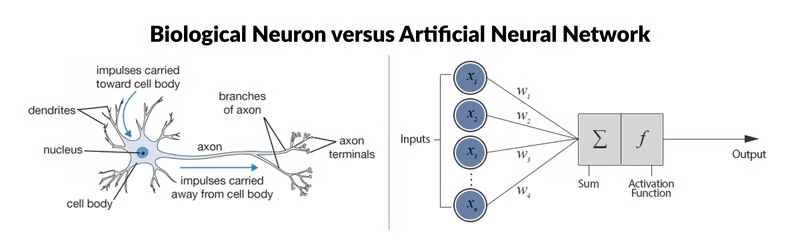

## Set up environment

In [1]:
import numpy as np
np.random.default_rng(42)

import pandas as pd
from pandas import DataFrame

from typing import List, Callable

from matplotlib import pyplot as plt

from graphviz import Digraph

import functools

## Hyperparams

In [ ]:
TEST_SIZE = 0.1

# 1e-2 is too high for 2 neurons (exploding gradients)
LEARNING_RATE = 1e-3
BATCH_SIZE = 4
EPOCHS = 500

HIDDEN_LAYERS_NUM = 1
HIDDEN_NEURONS_NUM = 1


## Utilities

In [3]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Load data

In [4]:
df = pd.read_csv("ice_cream_data.csv", sep=",")
df = df.sample(frac=1, random_state=42)
df.head()

,Temperature,Is_Weekend,Ice_Creams_Sold
110,18.692544,1,203
419,32.571236,0,275
565,27.697531,1,274
77,12.221340,0,104
181,13.404206,0,136


### Separate input from target

In [5]:
targets = df["Ice_Creams_Sold"]
inputs = df.drop(["Ice_Creams_Sold"], axis=1)

In [6]:
inputs.min()

Temperature    10.151848
Is_Weekend      0.000000
dtype: float64

In [7]:
inputs.max()

Temperature    39.99153
Is_Weekend      1.00000
dtype: float64

### Normalize input

In [8]:
def normalize_input(X: DataFrame):
    result = (X - X.min()) / (X.max() - X.min())
    return result

In [9]:
norm_inputs = normalize_input(inputs)

In [10]:
norm_inputs.min()

Temperature    0.0
Is_Weekend     0.0
dtype: float64

In [11]:
norm_inputs.max()

Temperature    1.0
Is_Weekend     1.0
dtype: float64

### Numpy

In [12]:
inputs = norm_inputs.to_numpy()
inputs[:5]

array([[0.2862194 , 1.        ],
       [0.75132798, 0.        ],
       [0.58799831, 1.        ],
       [0.06935369, 0.        ],
       [0.10899439, 0.        ]])

In [13]:
inputs.shape

(600, 2)

In [14]:
targets = targets.to_numpy()
targets[:5]

array([203, 275, 274, 104, 136])

### Train vs. Test set

In [15]:
test_size = int(len(inputs) * TEST_SIZE)
print(f"Train size: {len(inputs) - test_size}, Test size: {test_size}")

inputs_train = inputs[:-test_size]
targets_train = targets[:-test_size]

inputs_test = inputs[-test_size:]
targets_test = targets[-test_size:]

Train size: 540, Test size: 60


## Train Model

### Model

In [16]:
class Variable:
    def __init__(self, label = "", data = 0.0, _children = (), _op = "", trainable = False):
        self.label = label
        self._forward = None
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._trainable = trainable

        self._prev = set(_children)
        self._op = _op

    def __str__(self):
        return f"{self.label}:{self.data}"

    def __add__(self, other):
        result = Variable(_children=(self, other), _op="+")

        def forward():
            return self.forward() + other.forward()
        result._forward = forward

        def backward():
            self.grad = 1.0 * result.grad
            other.grad = 1.0 * result.grad
        result._backward = backward
        
        return result

    def __mul__(self, other):
        result = Variable(_children=(self, other), _op="*")

        def forward():
            return self.forward() * other.forward()
        result._forward = forward
        
        def backward():
            self.grad = other.data * result.grad
            other.grad = self.data * result.grad
        result._backward = backward

        return result
    
    def tanh(self):
        result = Variable(_children=(self,), _op="tanh")

        def forward():
            return np.tanh(self.forward())
        result._forward = forward
        
        def backward():
            self.grad = (1 - np.tanh(self.data) ** 2) * result.grad
        result._backward = backward

        return result
    
    def mse(self, target):
        result = Variable(_children=(self, target), _op="mse")

        def forward():
            return (target.forward() - self.forward()) ** 2
        result._forward = forward

        def backward():
            self.grad = 2 * (self.data - target.data)
            target.grad = 2 * (target.data - self.data)
        result._backward = backward

        return result

    def forward(self):
        if self._forward:
            self.data = self._forward()
        return self.data

    def backward(self):
        # Base case
        self.grad = 1.0
        self._backward()

        nodes = list(self._prev)
        while nodes:
            node = nodes.pop()
            nodes.extend(list(node._prev))
            node._backward()
            if (node._trainable):
                node.data = node.data - node.grad * LEARNING_RATE

In [17]:
def neuron(inputs: List):
    bias = Variable(label="bias", data=0.01, trainable=True)

    weighted_inputs = []
    for index, input in enumerate(inputs):
        weight = Variable(label=f"weight{index}", data=np.random.uniform(-0.1, 0.1), trainable=True)
        weighted_input = input * weight
        weighted_input.label = f"weighted_input{index}"
        weighted_inputs.append(weighted_input)

    weighted_input_sum = functools.reduce(lambda x, y: x + y, weighted_inputs)
    weighted_input_sum.label = "weighted_input_sum"

    biased_sum = weighted_input_sum + bias
    biased_sum.label = "sum"

    output = biased_sum
    # TODO: add classification case
    # output = biased_sum.tanh()
    output.label = "output"

    return output

In [18]:
input1 = Variable("input1")
input2 = Variable("input2")
target = Variable("target")

hidden_neurons = []
for neuron_index in range(HIDDEN_NEURONS_NUM):
    hidden_neuron_output = neuron([input1, input2])
    hidden_neurons.append(hidden_neuron_output)

output_neuron_output = neuron(hidden_neurons)

loss = output_neuron_output.mse(target)
loss.label = "loss"

### Training

In [19]:
data_size_train = len(inputs_train)
data_size_test = len(inputs_test)

history = {"train_loss": [], "test_loss": []}
for epoch in range(EPOCHS):
    losses_train = []
    losses_test = []

    # Validation
    for input_index in range(data_size_test):
        input1.data = inputs_test[input_index][0]
        input2.data = inputs_test[input_index][1]
        target.data = targets_test[input_index]

        loss_value_test = loss.forward()
        losses_test.append(loss_value_test)

    # Training
    for batch_index in range(data_size_train // BATCH_SIZE):
        losses = []
        for input_index in range(BATCH_SIZE):
            index = batch_index * BATCH_SIZE + input_index
            input1.data = inputs_train[index][0]
            input2.data = inputs_train[index][1]
            target.data = targets_train[index]

            loss_value = loss.forward()
            losses.append(loss_value)
        
        loss_value_train = np.array(losses).sum() / len(losses)
        losses_train.append(loss_value_train)

        loss.data = loss_value_train
        loss.backward()

    # History for learning curve
    average_loss_train = np.array(losses_train).sum() / len(losses_train)
    average_loss_test = np.array(losses_test).sum() / len(losses_test)
    history["train_loss"].append(average_loss_train)
    history["test_loss"].append(average_loss_test)

    print(f"Epoch {epoch}: loss={average_loss_train}, test_loss={average_loss_test}")

    # Early Stopping
    patience = 10
    delta = 1
    train_losses = history["train_loss"]
    if len(train_losses) >= patience and all(
        abs(train_losses[-i] - train_losses[-i - 1]) <= delta for i in range(1, patience)
    ):
        break

Epoch 0: loss=6110.713013072175, test_loss=58484.66759897427
Epoch 1: loss=685.7399563080187, test_loss=202.03601848991946
Epoch 2: loss=677.6165983723398, test_loss=195.3991553147378
Epoch 3: loss=673.4570033259961, test_loss=192.8991581023206
Epoch 4: loss=670.9473153284082, test_loss=191.53366653333416
Epoch 5: loss=669.1322273547933, test_loss=190.76228069052362
Epoch 6: loss=667.6260806906895, test_loss=190.31312977995356
Epoch 7: loss=666.2665143341655, test_loss=190.04549157482603
Epoch 8: loss=664.9821832664362, test_loss=189.8835673451891
Epoch 9: loss=663.7401846358923, test_loss=189.78490266455688
Epoch 10: loss=662.5244987496976, test_loss=189.72488444441336
Epoch 11: loss=661.3268674066101, test_loss=189.6888413609225
Epoch 12: loss=660.1427905726622, test_loss=189.66784383357407
Epoch 13: loss=658.969690277612, test_loss=189.65637504514174
Epoch 14: loss=657.8060246902369, test_loss=189.65099090508582
Epoch 15: loss=656.6508369538973, test_loss=189.64952588180776
Epoch 16

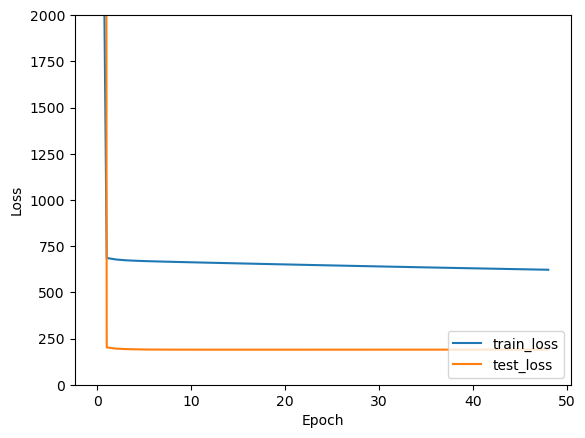

In [27]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 2000)
plt.legend(loc="lower right")

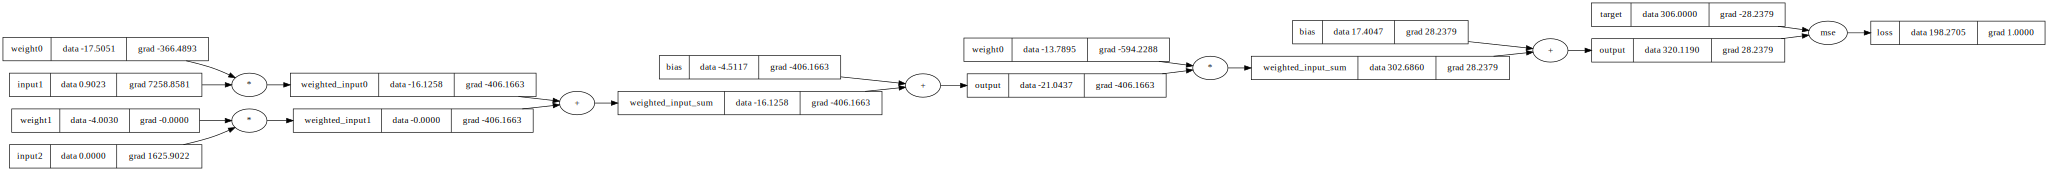

In [21]:
draw_dot(loss)

## Test solution

In [22]:
losses = []
for index in range(len(inputs_test)):
    input1.data = inputs_test[index][0]
    input2.data = inputs_test[index][1]
    target.data = targets_test[index]
    loss_value = loss.forward()
    losses.append(loss_value)

In [23]:
average_loss = np.array(losses).sum() // len(losses)

In [24]:
rmse = np.sqrt(np.mean(losses))
mean_target = np.mean(targets)
print("RMSE:", rmse)
print("Mean of targets:", mean_target)

RMSE: 13.781354722447933
Mean of targets: 216.425
